# Modeling LGN-V1 connections

This notebook will be used to model/schematize the construction of V1 receptive fields from LGN inputs. In particular, we want to analyze how the spatial arrangement of inputs and the tuning of the LGN neurons themselves influence V1 selectivity, and ask if the LGN arrangement/tuning matters for all - or only some - V1 neurons.

Last access (y.m.d):  20.01.21  
Last update (y.m.d):  20.01.21  

In [1]:
import numpy as np
import autoreload
import helper_fcns as hf
import lgn_v1
from scipy.ndimage import gaussian_filter as gauss_filt
import itertools
import os
import warnings
warnings.filterwarnings('once')

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import seaborn as sns

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/LGN_V1/' # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incom

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42 # should be 42; 3 works if there are kerning issues
rcParams['ps.fonttype'] = 42 # should be 42; 3 works if there are kerning issues

# Haphazard wiring

Let's try and recreate Ringach 2004. Here, he defines a hexagonal latice: 

$\vec{\mathbf{x}}$ = $\lambda$ * $\begin{pmatrix} 1 & 1 \\\ \sqrt{3} & -\sqrt{3} \end{pmatrix}$ * $\begin{pmatrix} i \\\ j \end{pmatrix}$ + $\vec{n}$

### First, the retinal mosaic

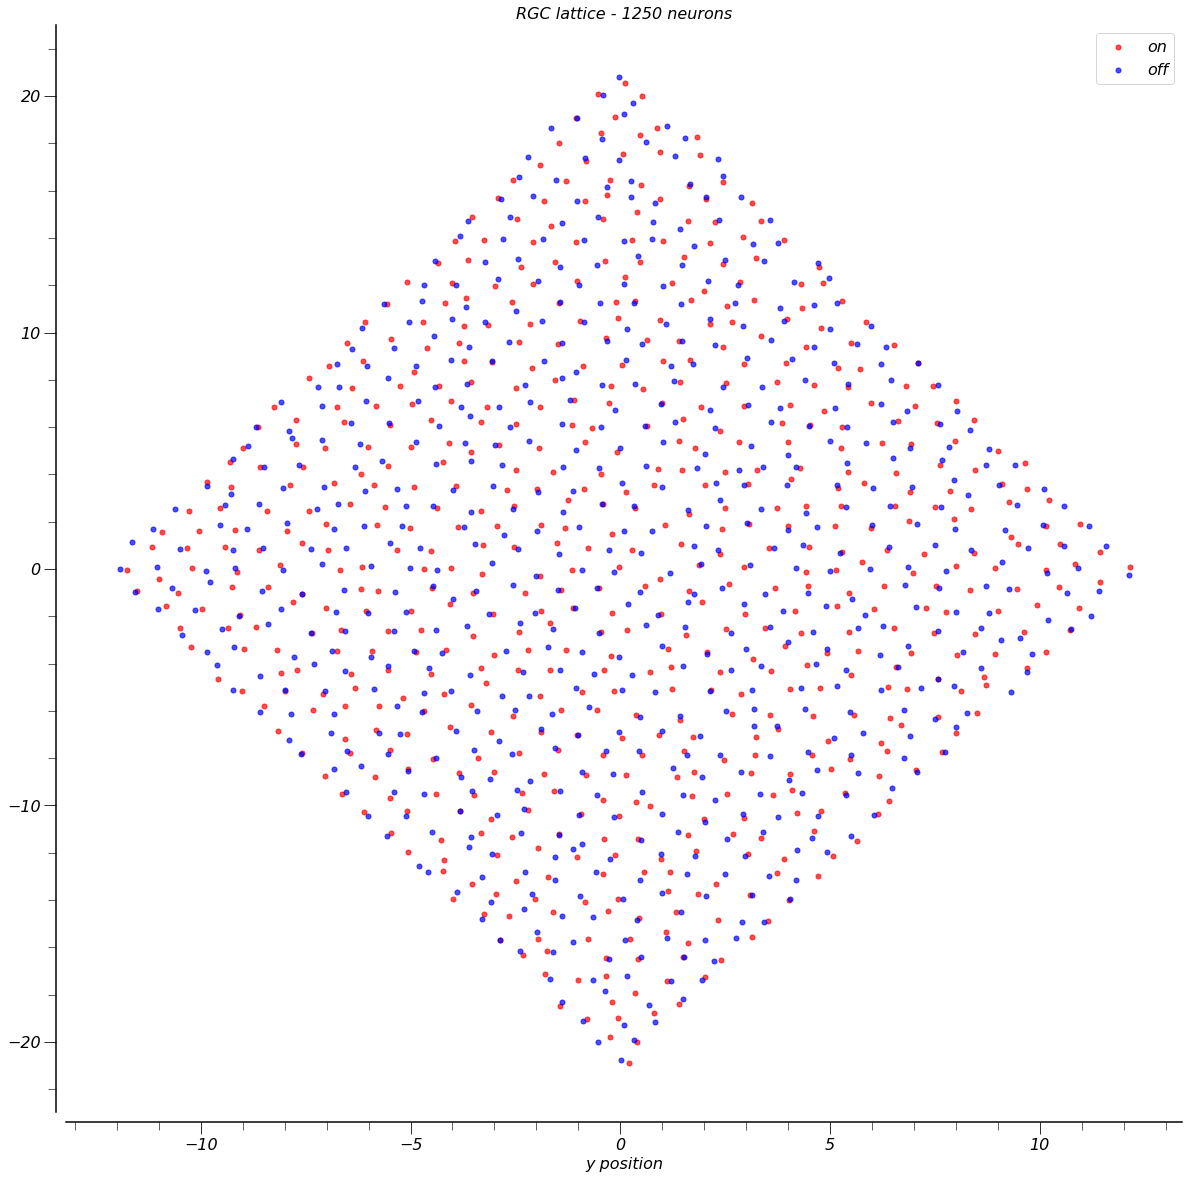

In [17]:
latNum = latNum+1;
# latNum = 5;

nsteps = 12;
sc_factor=1/2.0;
lm=1;
sig_ringach = 0.155;

on_locs, off_locs = lgn_v1.rgc_lattice(nsteps, sc_factor=sc_factor, lm=lm, sig_pos=sig_ringach)
f = plt.figure(figsize=(20, 20));

plt.scatter(on_locs[:, 0], on_locs[:, 1], c='r', alpha=0.7, label='on');
plt.scatter(off_locs[:, 0], off_locs[:, 1], c='b', alpha=0.7, label='off');

plt.axis('equal');
plt.axis('tight');
plt.xlabel('x position')
plt.xlabel('y position')
plt.title('RGC lattice - %d neurons' % (len(on_locs)+len(off_locs)));
plt.legend();
sns.despine(offset=10)

In [15]:
### Now, compute the distribution of distances between locations - first within class then, across
# within class:
on_min = [];
off_min = [];
for i,j in zip(on_locs, off_locs):
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    on_min.append(np.partition(np.sqrt(np.sum(np.square(i - on_locs), 1)), 1)[1])
    off_min.append(np.partition(np.sqrt(np.sum(np.square(j - off_locs), 1)), 1)[1])

for dta, lbl in zip((on_min, off_min), ('on', 'off')):
    mn, sd = np.mean(dta), np.std(dta);
    cv = np.divide(sd, mn);
    print('%s: mn %.2f +- %.2f --- CV %.3f' % (lbl, mn, sd, cv))
    
# independent of class:
all_locs = np.vstack((on_locs, off_locs));
both_min = [];
for i in all_locs:
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    both_min.append(np.partition(np.sqrt(np.sum(np.square(i - all_locs), 1)), 1)[1])
    
mn_both, sd_both = np.mean(both_min), np.std(both_min);
cv_both = np.divide(sd_both, mn_both);
print('%s: mn %.2f +- %.2f --- CV %.3f' % ('all locations', mn_both, sd_both, cv_both))

on: mn 0.74 +- 0.14 --- CV 0.182
off: mn 0.76 +- 0.13 --- CV 0.169
all locations: mn 0.27 +- 0.14 --- CV 0.504


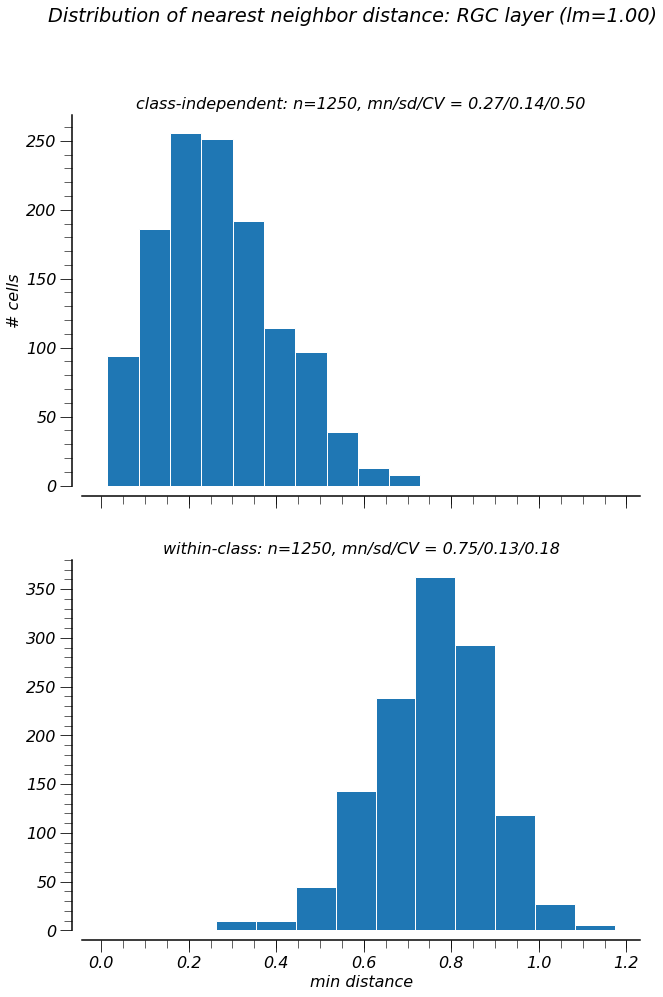

In [16]:
all_dist_within = np.hstack((on_min, off_min));
all_mean, all_std = np.mean(all_dist_within), np.std(all_dist_within);
all_cv = np.divide(all_std, all_mean)

fDistr, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
fDistr.suptitle('Distribution of nearest neighbor distance: RGC layer (lm=%.2f)' % lm)

sns.despine(offset=10)

ax[0].hist(both_min);
ax[0].set_title('class-independent: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(both_min), mn_both, sd_both, cv_both));
ax[0].set_ylabel('# cells');

ax[1].hist(all_dist_within);
ax[1].set_title('within-class: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(all_dist_within), all_mean, all_std, all_cv));
ax[1].set_xlabel('min distance');


In [ ]:
### Save the lattice and the distributions

f_lat = [f, fDistr]; # in future, add fLat before this

curr_name = 'lat%03d_distr.pdf' % (latNum)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + curr_name);
for fc in f_lat:
    # first, save png of just the one figure
    # then, add to the pdf
    pdfSv.savefig(fc)
    plt.close(fc)
pdfSv.close();

### Then, create the LGN layer

_"The layer of LGN neurons was constructed by replicating the original RGC layer and adding 1.5 times more receptive fields. This was done by random sampling (with replacement) to result in a total of 2.5 times the number of original RGCs. This assumes that each LGN neuron receives dominant input from only one retinal afferent (Cleland and Lee 1985; Cleland et al. 1971)"_ - Ringach, 2004

In [23]:
# so, let's sample from "all_locs", which combines the locations of on- and off-center RGC. 
# but, we'll keep track of on and off identity

all_locs = np.vstack((on_locs, off_locs));
all_ids = np.hstack((np.ones((len(on_locs), )), np.zeros((len(off_locs), ))));

n_RGC = len(all_locs);
n_to_draw = np.int(0*n_RGC) 
# resampling 1.5x the RGC layer is for cat
# -- we can assume 1:1 for RGC:LGN in monkey, thus no resampling needed, so n_to_draw is 0!

inds = np.random.randint(low=0, high=n_RGC, size=n_to_draw)
new_locs = all_locs[inds];
new_ids = all_ids[inds];

LGN_locs = np.vstack((all_locs, new_locs))
LGN_ids = np.hstack((all_ids, new_ids))

on_inds = np.where(LGN_ids == 1)[0];
off_inds = np.where(LGN_ids == 0)[0];

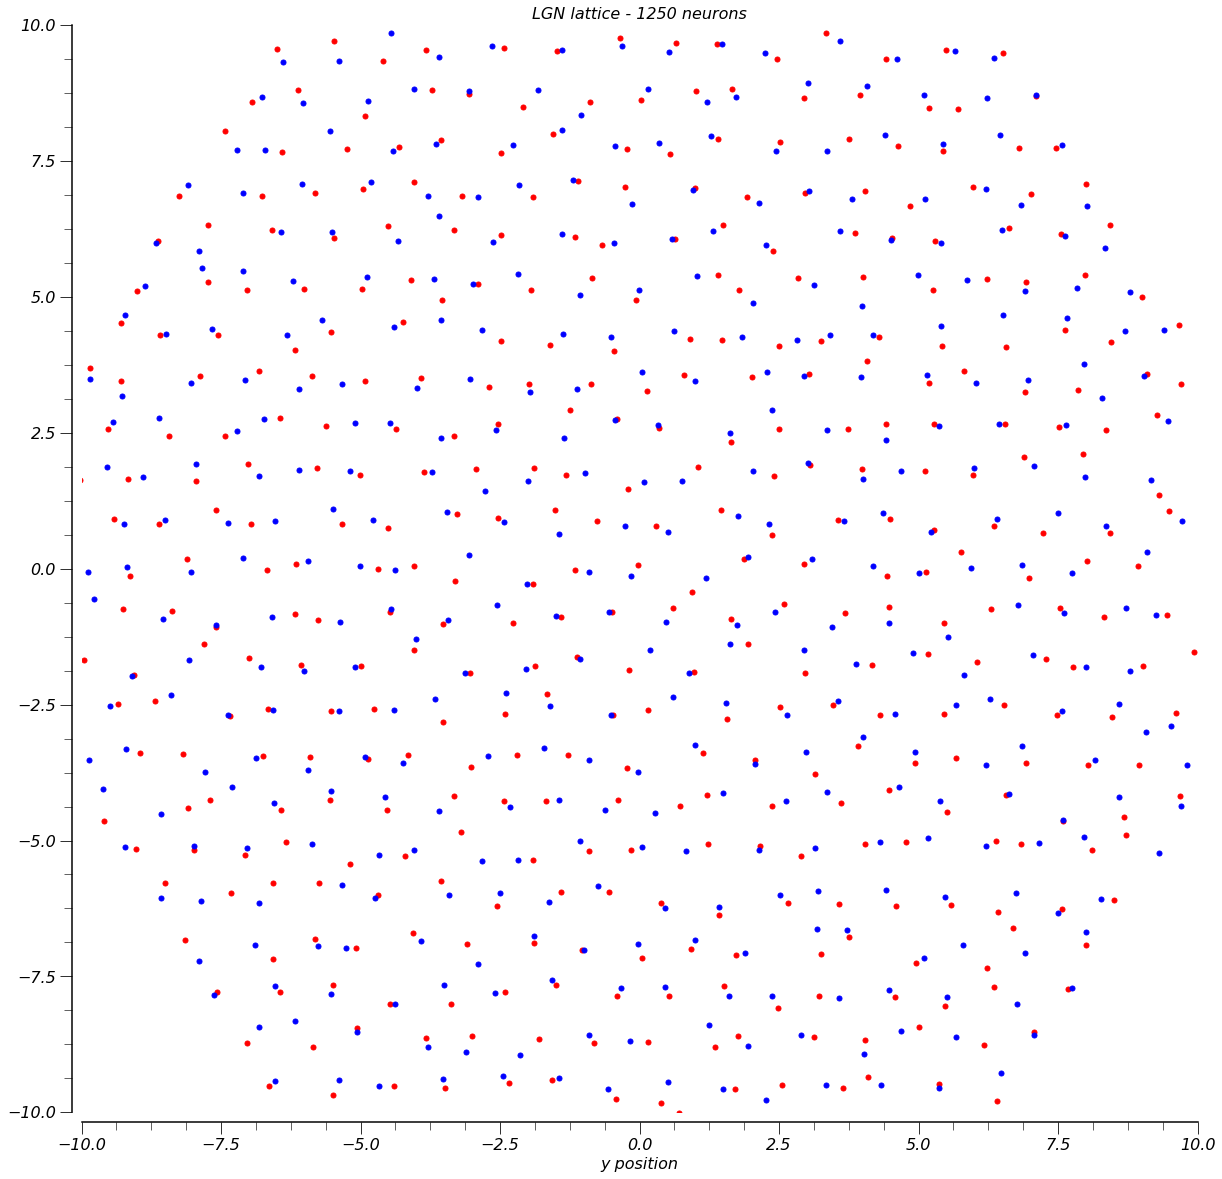

In [25]:
# now, let's plot
# -- by reducing the "alpha" of each point, it's visible which points have been resampled
#      simply because the multiple overlaid points will appear darker!

to_plt = 1;

if to_plt:
    fLGN = plt.figure(figsize=(20, 20))

for i, loc in enumerate(LGN_locs):

    # on or off?
    is_on = LGN_ids[i];
    if is_on == 1:
        c = 'r';
    else:
        c= 'b'
    
    ## first "on"
    if to_plt:
        if len(new_locs) == 0: # i.e. no extra resampling done...so LGN is just RGC
            alph = 1;
        else:
            alph = 0.1;
        plt.scatter(loc[0], loc[1], c=c, alpha=alph, label='on')

if to_plt:
    sns.despine(offset=10)
    plt.axis('equal');
    plt.axis('tight');
    plt.xlabel('x position')
    plt.xlabel('y position')
    plt.title('LGN lattice - %d neurons' % len(LGN_locs))
    # now, trim the figure so that we make it a square
    plt.xlim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);
    plt.ylim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);

### Now, draw LGN inputs for the V1 layer, and assign synaptic weights

"Next, we have to decide on the size of the RGC center. Wassle and co-workers have shown that the dendritic field radius is approximately the same as the mean nearest neighbor distance in the mosaic, which equals  0.76 . However, the physiological receptive field center is slightly larger than the actual dendritic tree, with the amplitude decaying to about 30% of its peak at the boundary of the dendritic tree (Peichl and Wassle 1983). To match this value, we selected the center of the RGC to be a two-dimensional Gaussian function with SD equal to $\sigma_{ctr} = 0.7 * \lambda$.

Then, probability of LGN (at $\vec{x}$) and V1 connection (at $\vec{y}$) is $p = p_{max} \exp(-\frac{{\mid{\vec{x}-\vec{y}}}\mid^2}{2\sigma_{conn}^2})$ where $\sigma_{conn} = 0.97*\sigma_{ctr}$ and $p_{max}=0.85$

In [35]:
ctrMult = 0.7;
sig_ctr = ctrMult*lm; # what if the fields are really small?
pmax = 0.85; # 0.85 is default
connMult = 0.97; # default is 0.97
sig_conn = connMult*sig_ctr;
smax = 1;
sig_syn = 1.1*sig_ctr; # 1.1

# let's decide how far to look
near_thresh = 3; # meaning we only bother with looking for connecting cells with distance < near_thresh

# how finely will we sample the grid? and over what x range?
# - let's go +/- X*near_thresh in sampling! (x=1.5 is good start)
bnds = 70*near_thresh;
n_samps = 1001; # N samples over the total range (which is [-bnds, bnds])
# and, what is the sampling period?
samp_step = np.round(2*bnds/n_samps, 3);

# sum(dist, 1) means we can pass in list of X and Y coordinates
gauss = lambda x, y, scale, sig: scale*np.exp(-(np.sum(np.square(x-y), 1))/(2*np.square(sig)))

p = lambda x, y: gauss(x, y, pmax, sig_conn) # probability of connection
s = lambda x, y: gauss(x, y, smax, sig_syn) # strength of connection

#### Compute an example RF

In [27]:
#################
#################
#################
### WARNING: THIS WILL RECREATE THE V1 NEURON - do this ONLY if you want a new neuron
#################
#################
#################

# pick a V1 location - then, compute all of the LGN neurons with a RF whose distance is less than "near_thresh" from 
# that V1 location
# - from there, we compute if the cell is connected (based on "p" eq. above) and assign a strength (from "s" above)

exNum = 0;
# exNum = exNum + 1;

# -- first, random location
rand_dist = 0.4*nsteps*np.random.random()
rand_phi = 2*np.pi*np.random.random()-np.pi;
# now, put into cartesian coordinates
xcr, ycr = rand_dist*np.cos(rand_phi), rand_dist*np.sin(rand_phi)
v1_loc = [xcr, ycr];
# v1_loc = [-2, 5.4];

# -- now, compute the distance and find which LGN neurons are near
curr_dist = np.sqrt(np.sum(np.square(v1_loc - LGN_locs), 1));
LGN_near = np.where(curr_dist < near_thresh)[0]

# -- compute the connection probability, see which are connected, and compute sign/weight of those connected ones
conxn_prob = p(v1_loc, LGN_locs[LGN_near]);

which_connected = np.where(np.random.binomial(1, conxn_prob))[0];
not_connected = np.setdiff1d(np.arange(len(LGN_near)), which_connected);
which_on  = np.where(LGN_ids[LGN_near[which_connected]]==1);
which_off = np.where(LGN_ids[LGN_near[which_connected]]==0);

on_str = s(v1_loc, LGN_locs[LGN_near[which_connected[which_on]]])
off_str = s(v1_loc, LGN_locs[LGN_near[which_connected[which_off]]])


#################
#################
#################
### WARNING: THIS (above) WILL RECREATE THE V1 NEURON - do this ONLY if you want a new neuron
#################
#################
#################

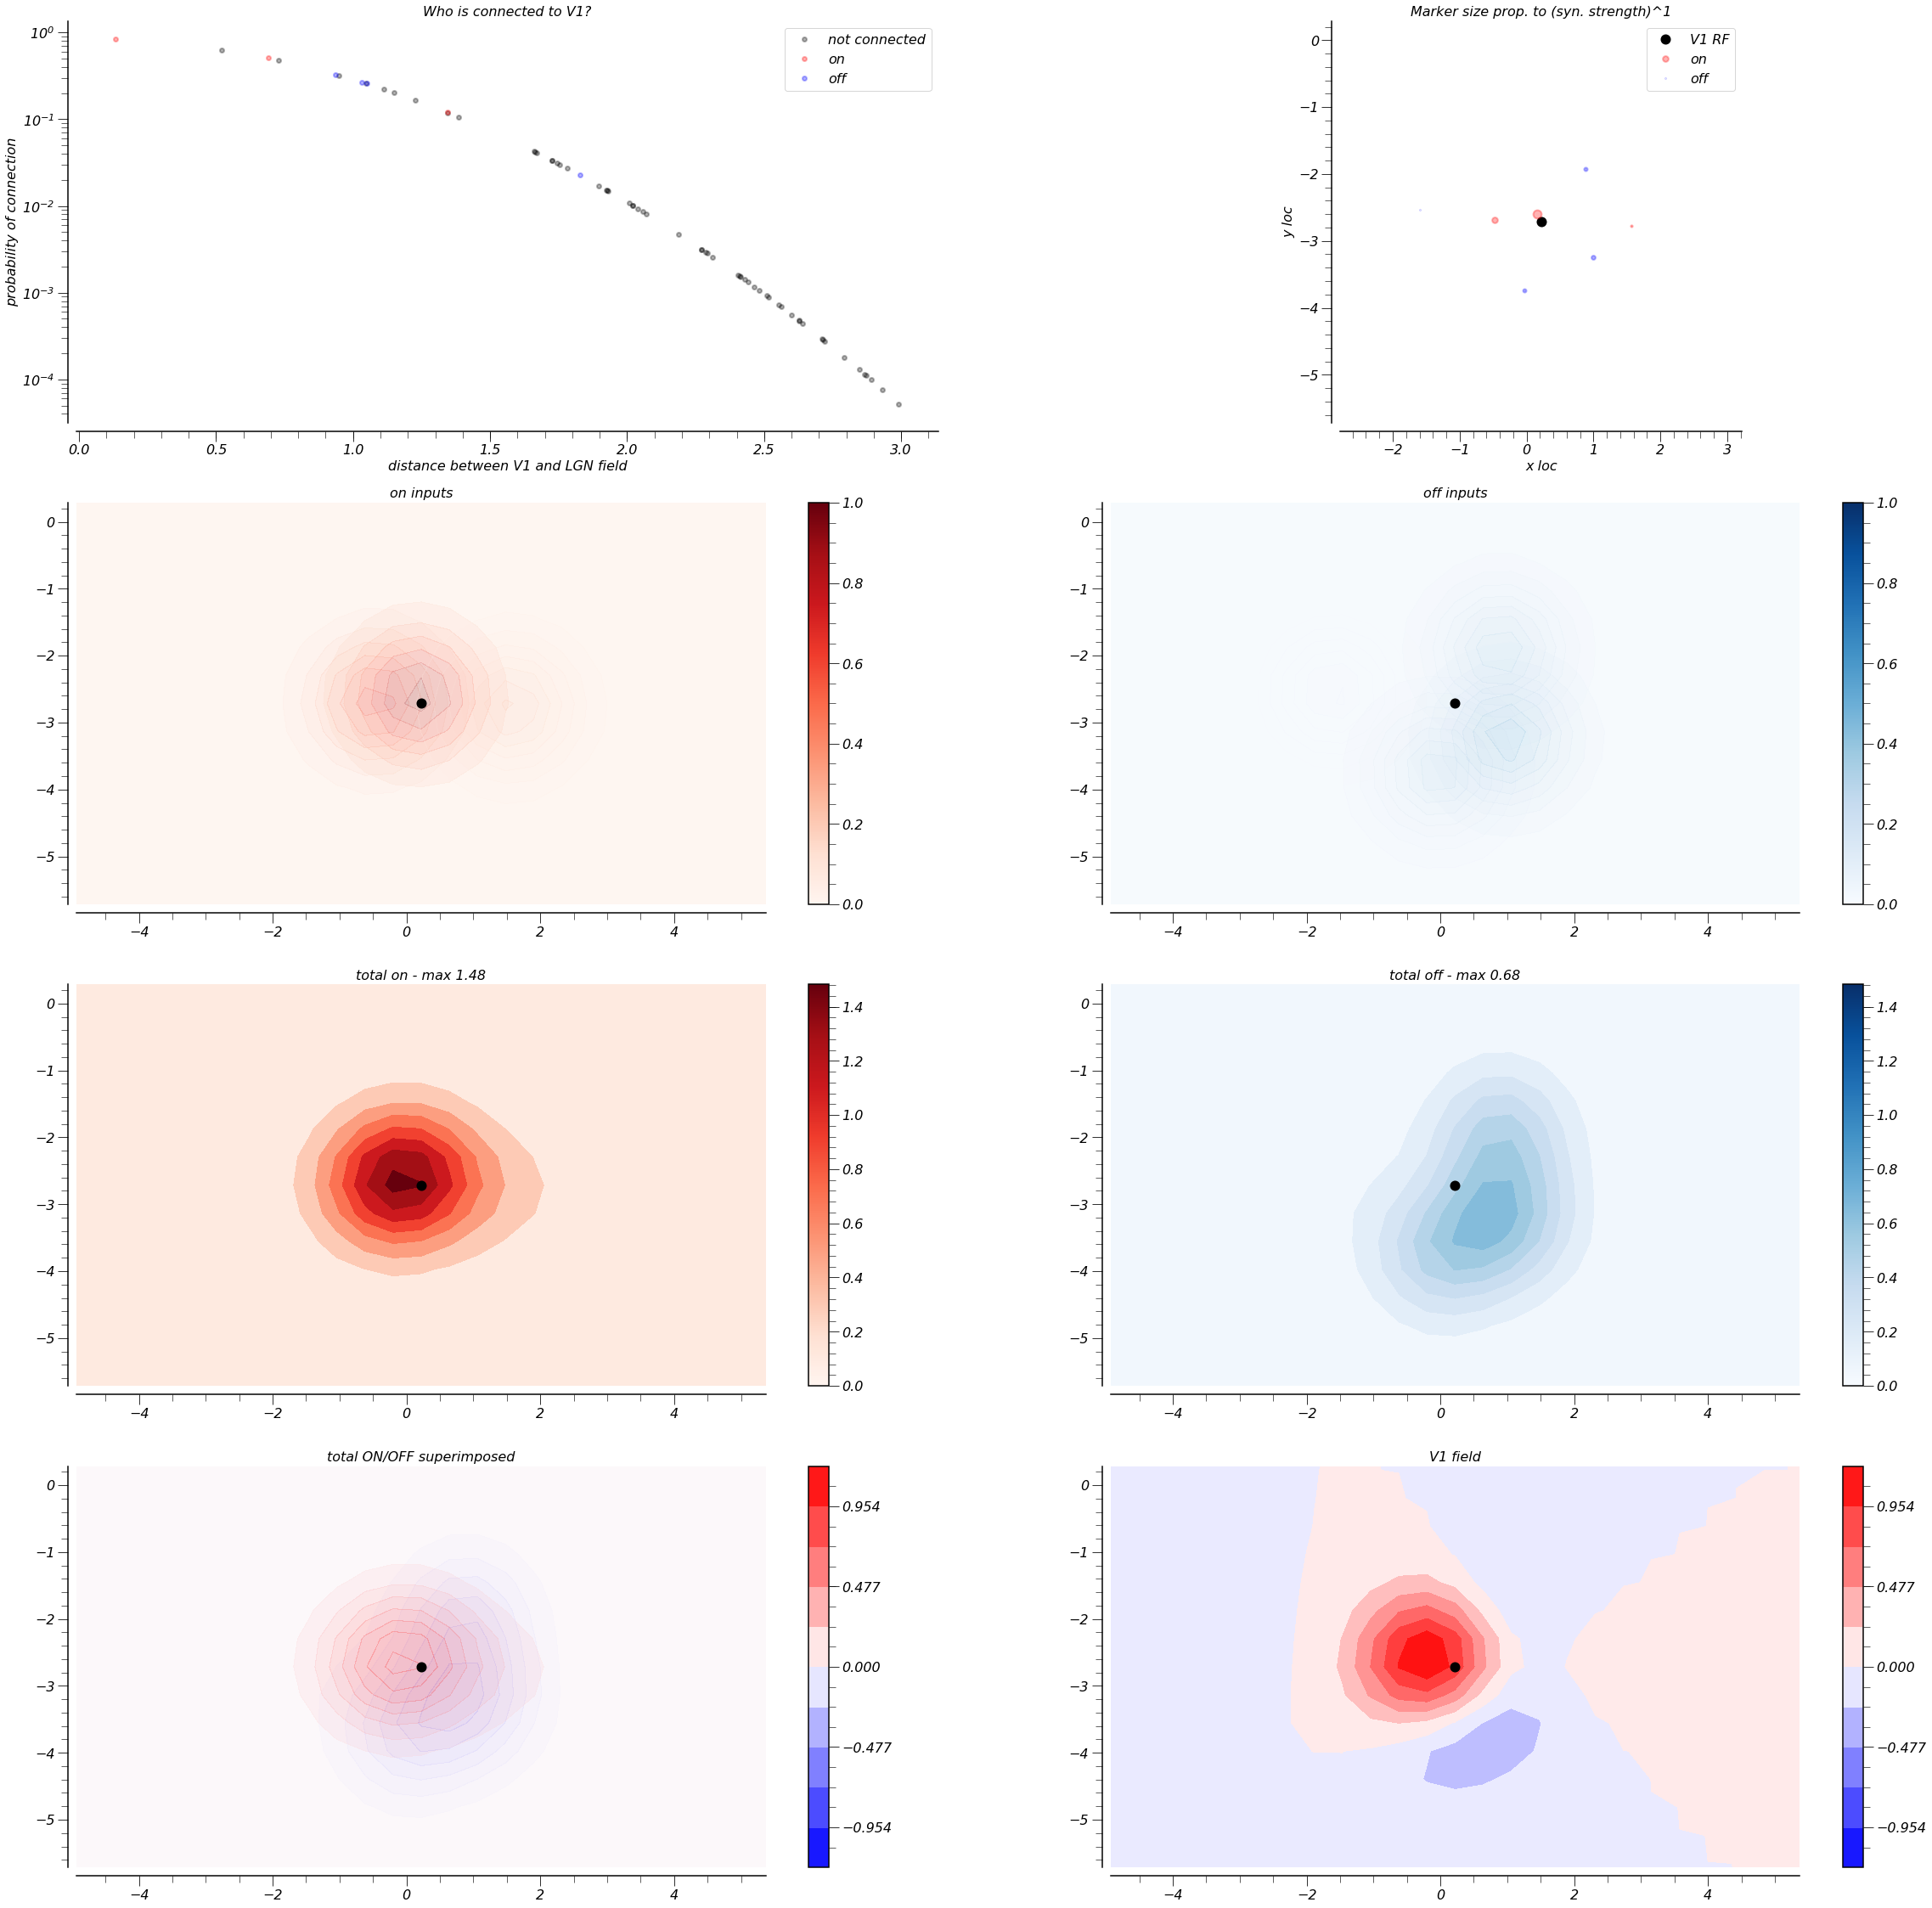

In [36]:
# quick aside: plot probability of connection as a function of calculated distance
# -- and which are actually connected

nrow, ncol = 4, 2
fConstr, ax = plt.subplots(nrow, ncol, figsize=(10*nrow, 20*ncol))

# some overall plot parameters
v1_size = 10; # marker size for plot

# plot all possible connections and show which are made
ax[0, 0].plot(curr_dist[LGN_near[not_connected]], conxn_prob[not_connected], 'ko', label='not connected', alpha=0.3);
# on
ax[0, 0].plot(curr_dist[LGN_near[which_connected[which_on]]], conxn_prob[which_connected[which_on]], 'ro', label='on', alpha=0.3)
# off
ax[0, 0].plot(curr_dist[LGN_near[which_connected[which_off]]], conxn_prob[which_connected[which_off]], 'bo', label='off', alpha=0.3)
ax[0, 0].set_yscale('log')
# plt.xscale('log')
ax[0, 0].set_xlabel('distance between V1 and LGN field');
ax[0, 0].set_ylabel('probability of connection');
ax[0, 0].legend();
ax[0, 0].set_title('Who is connected to V1?');

# now, show the spatial location of these LGN fields relative to the V1 field
curr_on_locs = LGN_locs[LGN_near[which_connected[which_on]]];
curr_off_locs = LGN_locs[LGN_near[which_connected[which_off]]];
lcs = [curr_on_locs, curr_off_locs];
syn_wts = [on_str, off_str]
clrs = ['r', 'b'];
lbls = ['on', 'off'];
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
for lc, syn_wt, clr, lbl in zip(lcs, syn_wts, clrs, lbls):
    [ax[0, 1].plot(l[0], l[1], 'o', c=clr, label=lbl, alpha=0.3, markersize=v1_size*np.power(syn_w, 1)) for l,syn_w in zip(lc, syn_wt)];
ax[0, 1].set_xlabel('x loc');
ax[0, 1].set_ylabel('y loc');
ax[0, 1].axis('square');
xlims = [v1_loc[0]-near_thresh, v1_loc[0]+near_thresh];
ylims = [v1_loc[1]-near_thresh, v1_loc[1]+near_thresh];
ax[0, 1].set_xlim(xlims);
ax[0, 1].set_ylim(ylims);
ax[0, 1].legend();
ax[0, 1].set_title('Marker size prop. to (syn. strength)^1');

for rw in range(nrow-1):
    ax[rw+1, 0].axis('equal');
    ax[rw+1, 1].axis('equal');
    ax[rw+1, 0].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    ax[rw+1, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    # - and set the limits
    ax[rw+1, 0].set_xlim(xlims);
    ax[rw+1, 0].set_ylim(ylims);
    ax[rw+1, 1].set_xlim(xlims);
    ax[rw+1, 1].set_ylim(ylims);
    

### and now, the real plotting
# - first, get the grid to sample
xs = np.linspace(-bnds, bnds, n_samps) + v1_loc[0];
ys = np.linspace(-bnds, bnds, n_samps) + v1_loc[1];
xcoor, ycoor = np.meshgrid(xs, ys);
all_coords = np.transpose(np.vstack((xcoor.ravel(), ycoor.ravel())));

lgn_field = np.zeros(len(all_coords), )
on_sum = np.zeros_like(lgn_field);
off_sum = np.zeros_like(lgn_field)

##### TEMPORARY  #########
## Let's change the size of the LGN centers without adjusting the pooling probability or synaptic strength as
## a function of distance
ctrMult = 0.7;
sig_ctr = ctrMult*lm; # what if the fields are really small?
# sig_ctr = 2; # what if the fields are really big?
##### TEMPORARY - BAD #########

# first, ON
for i in range(len(curr_on_locs)):
    lgn_loc = curr_on_locs[i];

    curr_field = gauss(lgn_loc, all_coords, on_str[i], sig_ctr)
    on_sum = on_sum + curr_field;
    curr_plt = np.reshape(curr_field, (len(xcoor), len(ycoor)));
    ax[1, 0].contourf(xcoor, ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(np.reshape(curr_field, (len(xcoor), len(ycoor))))
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 0]);
ax[1, 0].set_title('on inputs')
    
# then, OFF
for i in range(len(curr_off_locs)):
    lgn_loc = curr_off_locs[i];

    curr_field = gauss(lgn_loc, all_coords, off_str[i], sig_ctr)
    off_sum = off_sum + curr_field;
    curr_plt = np.reshape(curr_field, (len(xcoor), len(ycoor)));
    ax[1, 1].contourf(xcoor, ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(np.reshape(curr_field, (len(xcoor), len(ycoor))))
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 1]);
ax[1, 1].set_title('off inputs')

# - then, which is stronger, overall - on or off?
mx_resp = np.maximum(np.max(on_sum), np.max(off_sum));

# --- on sum
on_plt = np.reshape(on_sum, (len(xcoor), len(ycoor)));
ax[2, 0].contourf(xcoor, ycoor, on_plt, vmin = 0, vmax = mx_resp, cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(np.reshape(on_plt, (len(xcoor), len(ycoor))))
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 0]);
ax[2, 0].set_title('total on - max %.2f' % np.max(on_sum))
    
# --- off sum
off_plt = np.reshape(off_sum, (len(xcoor), len(ycoor)));
ax[2, 1].contourf(xcoor, ycoor, off_plt, vmin = 0, vmax = mx_resp, cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(np.reshape(off_plt, (len(xcoor), len(ycoor))))
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 1]);
ax[2, 1].set_title('total off - max %.2f' % np.max(off_sum))

# NOW, get the full LGN field
lgn_field = on_sum - off_sum; # why MINUS? because these are off centers!
    
lgn_plot = np.reshape(lgn_field, (len(xcoor), len(ycoor)));
mn, mx = np.min(lgn_field), np.max(lgn_field); mx_ab = np.maximum(np.abs(mn), np.abs(mx));
ax[3, 1].contourf(xcoor, ycoor, lgn_plot, vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
ax[3, 1].set_title('V1 field')

m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(lgn_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 1]);

# -- and the two (total ON/total OFF), superimposed
ax[3, 0].contourf(xcoor, ycoor, -off_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);
ax[3, 0].contourf(xcoor, ycoor, on_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);

m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(lgn_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 0]);
ax[3, 0].set_title('total ON/OFF superimposed')

sns.despine(offset=10)

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


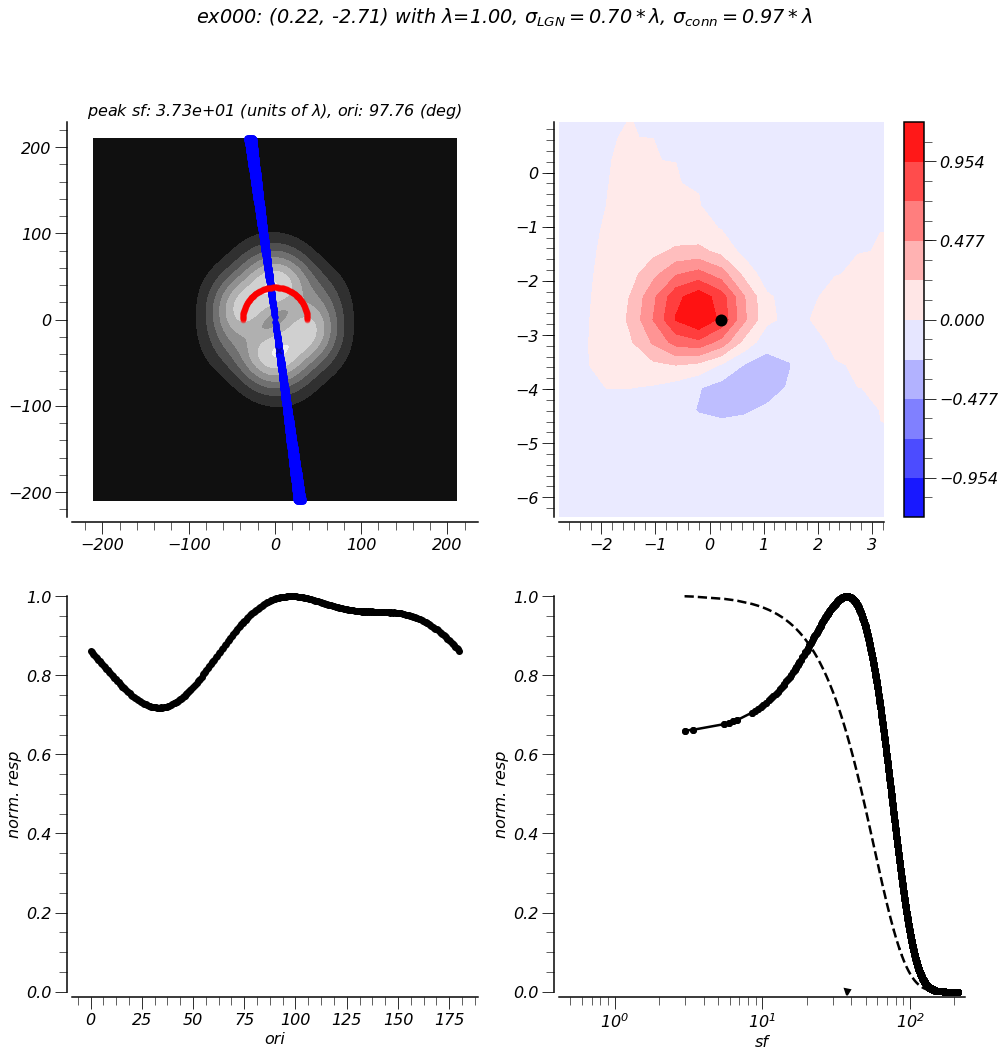

In [40]:
nr, nc = 2, 2;
fTune, ax = plt.subplots(nr, nc, figsize=(nc*8, nr*8))

#####
### plot the Fourier representation of the filter
#####
ft = np.fft.fft2(lgn_plot)
# - and what frequencies?? well, [-n_samps/2, n_samps/2]*freq_scale
freq_scale = samp_step;
freqs = freq_scale*np.linspace(-(n_samps/2), n_samps/2, n_samps)
xfreq, yfreq = np.meshgrid(freqs, freqs);
to_plot = np.abs(np.fft.fftshift(ft));
ax[0, 0].contourf(xfreq, yfreq, to_plot, cmap=cm.gray);
ax[0, 0].axis('equal');
## where is the peak of the filter? - per Tim's suggestion, let's first blur
filt_peak = np.argmax(to_plot);
xmax, ymax = np.unravel_index(filt_peak, to_plot.shape, order='F')
ax[0, 0].plot(freqs[xmax], freqs[ymax], 'kx', markersize=6, alpha=0.3)
# - cut the plot to zoom in on the relevant frequencies
xfr_peak, yfr_peak = freqs[xmax], freqs[ymax];
peak_sf = np.sqrt(np.square(xfr_peak) + np.square(yfr_peak));
peak_ori = np.mod(np.round(hf.angle_xy([xfr_peak], [yfr_peak])[0], 3), 180);
ax[0, 0].set_title(r'peak sf: %.2e (units of $\lambda$), ori: %.2f (deg)' % (peak_sf, peak_ori))
plt_bound = freq_scale*np.maximum(15*peak_sf, .55*freqs[-1]);
ax[0, 0].set_xlim([-plt_bound, plt_bound])
ax[0, 0].set_ylim([-plt_bound, plt_bound])

#####
# What is the tuning? i.e. SF and ORI?
#####
all_freqs = np.transpose(np.vstack((xfreq.ravel(), yfreq.ravel())));
# -- first, get the valid ori
oris = np.mod(hf.angle_xy(all_freqs[:, 0], all_freqs[:,1]), 180); # with no D.S., mod by 180
val_oris = np.where(np.mod(np.abs(oris-peak_ori), 180)<1)[0]; # np.deg2rad(5e-2) if radians
# -- then, the valid sfs
sfs = np.sqrt(np.square(all_freqs[:, 0])+np.square(all_freqs[:, 1]))
val_sfs = np.where(np.abs(sfs-peak_sf)<0.5*samp_step)[0];
#####
## NOW -- plot sf tuning measurements (fixed ori)
#####
plt_oris = val_oris[np.where(sfs[val_oris]<1.25*plt_bound)]
[ax[0, 0].scatter(freqs[x], freqs[y], c='b', alpha=1) for x,y in [np.unravel_index(p, to_plot.shape, order='F') for p in plt_oris]]
sf_vals = sfs[plt_oris]
sf_curve = to_plot[[x for x in np.unravel_index(plt_oris, to_plot.shape, order='C')]]
sf_order = np.argsort(sf_vals);
ax[1, 1].plot(np.maximum(peak_sf, samp_step), 0, 'kv', clip_on=False)
ax[1, 1].plot(sf_vals[sf_order], np.divide(sf_curve[sf_order], np.max(sf_curve)), 'k-o', clip_on=False)
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('sf');
ax[1, 1].set_ylabel('norm. resp');
ax[1, 1].set_xlim([samp_step, plt_bound]);
ax[1, 1].set_ylim([0, 1]);
## -- and get the LGN filter tuning, too
indiv_shp = np.reshape(curr_field, lgn_plot.shape) # curr_field is just any of the LGN fields - they're identical!
indiv_ft = np.fft.fft2(indiv_shp)
indiv_plot = np.abs(np.fft.fftshift(indiv_ft));
# ---- and evaluate at the same locations
lgn_curve = indiv_plot[[x for x in np.unravel_index(plt_oris, to_plot.shape, order='F')]]
ax[1, 1].plot(sf_vals[sf_order], np.divide(lgn_curve[sf_order], np.max(lgn_curve)), 'k--', clip_on=False)
#####
## THEN -- plot ori tuning measurements (fixed SF)
#####
core_oris = np.where(np.array([np.round(freqs[y], 3) for x,y in [np.unravel_index(d, to_plot.shape, order='F') for d in val_sfs]])>=0);
plt_sfs = val_sfs[core_oris]
[ax[0, 0].scatter(freqs[x], freqs[y], c='r', alpha=0.3) for x,y in [np.unravel_index(d, to_plot.shape, order='F') for d in plt_sfs]]
ori_vals = oris[plt_sfs]
ori_curve = to_plot[[x for x in np.unravel_index(plt_sfs, to_plot.shape, order='C')]]
ori_order = np.argsort(ori_vals);
ax[1, 0].plot(ori_vals[ori_order], np.divide(ori_curve[ori_order], np.max(ori_curve)), 'k-o', clip_on=False)
ax[1, 0].set_xlabel('ori');
ax[1, 0].set_ylabel('norm. resp');
ax[1, 0].set_ylim([0, 1]);

#####
# --- show that we can reconstruct it back into the spatial domain
#####
ift = (np.fft.ifft2(ft))

m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(np.abs(ift))
m.set_clim(-mx_ab, mx_ab)
ax[0, 1].contourf(xcoor, ycoor, np.real(np.sign(ift))*np.abs(ift), vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[0, 1]);
ax[0, 1].axis('equal');
ax[0, 1].set_xlim(xlims);
ax[0, 1].set_ylim(ylims);
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');

sns.despine(offset=5)

# make overall title
fTune.suptitle(r'ex%03d: (%.2f, %.2f) with $\lambda$=%.2f, $\sigma_{LGN}=%.2f*\lambda$, $\sigma_{conn}=%.2f*\lambda$' % (exNum, v1_loc[0], v1_loc[1], lm, ctrMult, connMult));

In [ ]:
# now, combine and save
f_exCell = [fConstr, fTune];
plt_label = ['_constr', '_tune'];

nm_base = 'lat%03d_ex%03d' % (latNum, exNum);

curr_name = '%s_v1_LGN_%03d.pdf' % (nm_base, 100*sig_ctr)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
if not os.path.exists(save_loc + 'pdf_orig/'):
    os.makedirs(save_loc + 'pdf_orig/')
if not os.path.exists(save_loc + '%s/' % nm_base):
    os.makedirs(save_loc + '%s/' % nm_base)
pdfSv = pltSave.PdfPages(save_loc + 'pdf_orig/' + curr_name);
for fc, lbl in zip(f_exCell, plt_label):
    # first, save png of just the one figure
    fc.savefig(save_loc + nm_base + '/'  + curr_name.replace('.pdf', '%s.png' % lbl));
    # then, add to the pdf
    pdfSv.savefig(fc, dpi=5)
    plt.close(fc)
pdfSv.close();
